In [1]:
%matplotlib inline

import os
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

In [2]:
import desispec.io
import desisim.io
from desisim.obs import new_exposure
from desisim.scripts import quickgen
from desispec.scripts import group_spectra

/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
def check_env():
    for env in ('DESIMODEL', 'DESI_ROOT', 'DESI_SPECTRO_SIM', 'DESI_SPECTRO_DATA', 
            'DESI_SPECTRO_REDUX', 'SPECPROD', 'PIXPROD'):
        if env in os.environ:
            print('{} environment set to {}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))

In [5]:
check_env()

DESIMODEL environment set to /Users/ryanrubenzahl/Documents/DESI/code//desimodel
DESI_ROOT environment set to /Users/ryanrubenzahl/Documents/DESI
DESI_SPECTRO_SIM environment set to /Users/ryanrubenzahl/Documents/DESI/spectro/sim
DESI_SPECTRO_DATA environment set to /Users/ryanrubenzahl/Documents/DESI/spectro/data
DESI_SPECTRO_REDUX environment set to /Users/ryanrubenzahl/Documents/DESI/spectro/redux
SPECPROD environment set to dailytest
PIXPROD environment set to dailytest


In [6]:
%set_env SPECPROD=example
%set_env PIXPROD=example
rawdata_dir = desisim.io.simdir()
%set_env DESI_SPECTRO_DATA=$rawdata_dir

print('Simulated raw data will be written to {}'.format(desisim.io.simdir()))
print('Pipeline will read raw data from {}'.format(desispec.io.rawdata_root()))
print('    (without knowing that it was simulated)')
print('Paipeline will write processed data to {}'.format(desispec.io.specprod_root()))

env: SPECPROD=example
env: PIXPROD=example
env: DESI_SPECTRO_DATA=/Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/
Simulated raw data will be written to /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/
Pipeline will read raw data from /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/
    (without knowing that it was simulated)
Paipeline will write processed data to /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example


## Read in simulated spectra

In [7]:
flavor  = 'dark' # choose sky-brightness model and distribution of targets
flavors = ['dark', 'gray', 'grey', 'bright', 'bgs', 'mws', 'lrg', 'elg', 'qso', 'std', 'arc', 'flat'] # all options
night   = '20180201' # default is current date
expid   = 0 # exposure ID number, can use to simulate more than one DESI exposure

First get truth data of simulated objects

In [8]:
fiberfile   = desispec.io.findfile('fibermap', night=night, expid=expid)
simspecfile = desisim.io.findfile('simspec', night=night, expid=expid)

In [9]:
print('Reading simspec file {}.'.format(simspecfile))
hdu = fits.open(simspecfile)
hdu.info()
meta = Table(hdu['TRUTH'].data)
hdu.close()

Reading simspec file /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20180201/simspec-00000000.fits.
Filename: /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20180201/simspec-00000000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  WAVE          1 PrimaryHDU      58   (31900,)   float64   
  1  FLUX          1 ImageHDU         9   (31900, 1000)   float32   
  2  SKYFLUX       1 ImageHDU         9   (31900, 1000)   float32   
  3  WAVE_B        1 ImageHDU         7   (11896,)   float64   
  4  PHOT_B        1 ImageHDU         9   (11896, 1000)   float32   
  5  SKYPHOT_B     1 ImageHDU         9   (11896, 1000)   float32   
  6  WAVE_R        1 ImageHDU         7   (10575,)   float64   
  7  PHOT_R        1 ImageHDU         9   (10575, 1000)   float32   
  8  SKYPHOT_R     1 ImageHDU         9   (10575, 1000)   float32   
  9  WAVE_Z        1 ImageHDU         7   (11990,)   float64   
 10  PHOT_Z        1 ImageHDU         9   (11990, 1000)   floa

Now read in simulated spectra

In [10]:
cameras = ['b0', 'b1', 'r0', 'r1', 'z0', 'z1']
cframes = {camera: [] for camera in cameras}

In [11]:
# From using desispec.io.frame.read_frame
for camera in cameras:
    cframefile = desispec.io.findfile('cframe', 
                                      night=night, 
                                      expid=expid, 
                                      camera=camera)
    print('Reading {}'.format(cframefile))
    cframes[camera] = desispec.io.frame.read_frame(cframefile)
    


Reading /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example/exposures/20180201/00000000/cframe-b0-00000000.fits
Reading /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example/exposures/20180201/00000000/cframe-b1-00000000.fits
Reading /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example/exposures/20180201/00000000/cframe-r0-00000000.fits
Reading /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example/exposures/20180201/00000000/cframe-r1-00000000.fits
Reading /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example/exposures/20180201/00000000/cframe-z0-00000000.fits
Reading /Users/ryanrubenzahl/Documents/DESI/spectro/redux/example/exposures/20180201/00000000/cframe-z1-00000000.fits


In [12]:
cframes['b0']

<Frame: nspec=500, nwave=4760>

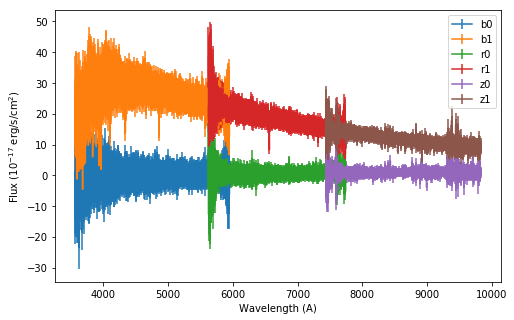

In [61]:
# Lets plot one of the spectra that we simulated
n = 41

fig, ax = plt.subplots(1,1, figsize=(8,5))
for camera in cameras:
    cframe = cframes[camera]
    
    ax.errorbar(cframe.wave, cframe.flux[n, :], 1/np.sqrt(cframe.ivar[n, :]), label=camera)
    ax.set_xlabel('Wavelength (A)')
    ax.set_ylabel('Flux ($10^{-17}$ erg/s/cm$^2$)')
ax.legend(loc='best')

## Spectral coaddition

Here we combine exposures from individual camera bands (b, r, z) into one exposure per camera, then combine the three cameras into one overall spectrum.

Overview on coaddition: https://desi.lbl.gov/DocDB/cgi-bin/private/RetrieveFile?docid=1056;filename=coadd.pdf;version=2

Test coaddition: `desispec/test/test_coadd.py`

Global coaddition: `desispec/scripts/updatecoadd.py`

In [62]:
from desispec.coaddition import Spectrum
from desispec.resolution import Resolution

In [63]:
# dir(cframes['b0'])

specobj1 = Spectrum(
cframes['b0'].wave,
flux=cframes['b0'].flux[0],
ivar=cframes['b0'].ivar[0],
resolution=Resolution(cframes['b0'].resolution_data[0]),
)

specobj2 = Spectrum(
cframes['b1'].wave,
flux=cframes['b1'].flux[0],
ivar=cframes['b1'].ivar[0],
resolution=Resolution(cframes['b1'].resolution_data[0]),
)

In [64]:
specobj1 += specobj2
specobj1.finalize()

KeyboardInterrupt: 

In [17]:
print specobj1.flux

[ 5.93990337 -6.06758869 -4.20943106 ..., -6.27092244  5.65672206
  5.8644593 ]


In [65]:
allspecs = []

for cband in [['b0', 'b1'], ['r0', 'r1'], ['z0', 'z1']]:
    # dir(cframes['b0'])
    c0, c1 = cband

    specobj1 = Spectrum(
    cframes[c0].wave,
    flux=cframes[c0].flux[n],
    ivar=cframes[c0].ivar[n],
    resolution=Resolution(cframes[c0].resolution_data[n]),
    )

    specobj2 = Spectrum(
    cframes[c1].wave,
    flux=cframes[c1].flux[n],
    ivar=cframes[c1].ivar[n],
    resolution=Resolution(cframes[c1].resolution_data[n]),
    )

    specobj1 += specobj2
    specobj1.finalize()
    allspecs.append(specobj1)

### Wavelength Grids
see: https://github.com/desihub/desispec/blob/master/doc/coadd.rst


|  Band |	Min(A)|	Max(A) | Nbins | Size(A)  |	Files  |
|------- |-------- |------- |------- |-------- |--------| 
|b	    |  3579.0 |	5938.8 | 3934  | 0.6 |	brick, band coadd |
|r	    |  5635.0 |	7730.8 | 3494  | 0.6 |	brick, band coadd |
|z	    |  7445.0 |	9824.0 | 3966  | 0.6 |	brick, band coadd |
|all	|  3579.0 |	9825.0 | 6247  | 1.0 |	global coadd |

In [42]:
print desispec.coaddition.global_wavelength_grid

[ 3579.  3580.  3581. ...,  9823.  9824.  9825.]


In [66]:
# Now combine the b, r, and z spectra into one final spectra
# First, get overall wavelength range of the spectrum
# Individual cameras have 0.5 A resolutions
# We make the final coadd spectrum uniformly spaced with 1.0 A
global_wavelength_grid = np.arange(np.min(allspecs[0].wave), 
                                  np.max(allspecs[2].wave + 0.5), 
                                  1.0, dtype=np.float32)

coadd_all_spectra = Spectrum(global_wavelength_grid)
# coadd_all_spectra = Spectrum(desispec.coaddition.global_wavelength_grid)
for coadd_band in allspecs:
    coadd_all_spectra += coadd_band

In [67]:
coadd_all_spectra.finalize()

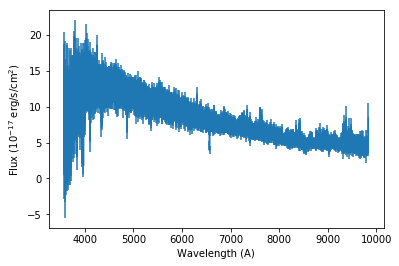

In [68]:
fig, ax = plt.subplots(1,1)

ax.errorbar(coadd_all_spectra.wave, coadd_all_spectra.flux, 1/np.sqrt(coadd_all_spectra.ivar))
ax.set_xlabel('Wavelength (A)')
ax.set_ylabel('Flux ($10^{-17}$ erg/s/cm$^2$)')

In [108]:
from desispec.io import write_frame

write_frame("test.fits", coadd_all_spectra)

AttributeError: 'Spectrum' object has no attribute 'meta'

In [111]:
from desispec.frame import Frame

frame = Frame(coadd_all_spectra.wave,
              coadd_all_spectra.flux, 
              coadd_all_spectra.ivar, 
              coadd_all_spectra.resolution)

AssertionError: 

In [123]:
def write_coadd_spectra(outfile, coadd_spectra):
    """
    Write the output of the full brz coadded spectra to a fits file.
    Include the truth and metadata from fiberfile and simspecfile
    """
    
    # Make parent directory if necessary
    dir, base = os.path.split(outfile)
    if not os.path.exists(dir):
        os.makedirs(dir)
        
    # Create HDUs from the data
    all_hdus = fits.HDUList()
    
    # metadata goes in empty primary HDU
    